# LIWC Analysis of Transcript with Speaker Identifiers
Preferred Transcript format:

    Speaker1: speech turn.
    Speaker2: speech turn.
   
Note: `Speaker1` and `Speaker2` are preferably single strings with no space in between. The separation between the speaker and the speech turn should be a colon (Dutch: doublepunt).

## Set up the Notebook
Since you are likely to run the notebook using Colab, you do not have to do change anything in the cell(s) below. However, if you plan to clone this repository and run it locally, please edit the cell below according to the instructions in the comments.

In [1]:
environment = 'local'

# Comment out the lines below until the line marked with '#---'
# !git clone https://github.com/senthilchandrasegaran/designing-intelligence
# %cd /content/designing-intelligence/notebooks/
# !git pull
# environment = 'colab'
#---

if environment == 'colab' :
    path = '/content/designing-intelligence/'
else :
    path = '../'

import re
import spacy
import itertools
import math
import warnings

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pprint as pp
import seaborn as sns

from collections import Counter
from IPython.display import Markdown, display
from matplotlib import rcParams
from spacy.lookups import Lookups
from spacy.lang.en import English

warnings.filterwarnings('ignore')

from IPython.display import Markdown, display

In [2]:
# Function to print output as markdown text (allows for some text decoration)
def printmd(string):
    display(Markdown(string))

## Read the Transcript
For now, this notebook is set up to read the transcript as a text file. Please refer to the sample transcript in the 'data' folder to see what it looks like. The cells below read the transcript and print it out for verification.

In [3]:
transcript_file_name = 'transcript-dana-annie.txt'
liwc_dictionary = 'causal-thinking.dic'

In [4]:
with open(path + 'data/' + transcript_file_name, 'r') as fo:
    transcript_text = fo.read()
    
def load_transcript_into_dataframe(transcript):
    transcript_lines = transcript.split('\n')
    processed_list = []
    for line in transcript_lines :
        if len(line.split(':')) > 1 :
            speaker = line.split(':')[0]
            speaker = speaker.strip()
            speaker = ('').join(speaker.split(' '))
            speech = (':').join(line.split(':')[1:])
            line_obj = { 'speaker' : speaker, 'speech_turn' : speech}
            processed_list.append(line_obj)
        else :
            speaker = processed_list[-1]['speaker']
            speaker = speaker.strip()
            speaker = ('').join(speaker.split(' '))
            speech = processed_list[-1]['speech_turn']
            new_speech = speech + ' ' + line
            processed_list[-1]['speech_turn'] = new_speech
    df = pd.DataFrame(processed_list)
    return df

transcript_df = load_transcript_into_dataframe(transcript_text)
transcript_df.sample(3)

,speaker,speech_turn
98,Dana,[Yeah. Maybe we should
10,Dana,It's just making a words ((laughing))
96,Dana,So now it's just giving information again. What


# LIWC Functions
The below cell is a set of functions that (very) slightly modified from [Chris Brown's LIWC analysis library](https://github.com/chbrown/liwc-python). It works the same way as his library is supposed to work, but edited here to address what seems to be encoding errors. Ignore the next cell for all practical purposes.

In [5]:
def tokenize(text):
    # you may want to use a smarter tokenizer
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)
        
def _parse_categories(lines):
    """
    Read (category_id, category_name) pairs from the categories section.
    Each line consists of an integer followed a tab and then the category name.
    This section is separated from the lexicon by a line consisting of a single "%".
    """
    for line in lines:
        line = line.strip()
        if '%' in line:
            return
        # ignore non-matching groups of categories
        if "\t" in line:
            category_id, category_name = line.split("\t", 1) # ORIGINAL
            yield category_id, category_name


def _parse_lexicon(lines, category_mapping):
    """
    Read (match_expression, category_names) pairs from the lexicon section.
    Each line consists of a match expression followed by a tab and then one or more
    tab-separated integers, which are mapped to category names using `category_mapping`.
    """
    for line in lines:
        line = line.strip()
        parts = line.split("\t")
        yield parts[0], [category_mapping[category_id] for category_id in parts[1:]]


def read_dic(filepath):
    """
    Reads a LIWC lexicon from a file in the .dic format, returning a tuple of
    (lexicon, category_names), where:
    * `lexicon` is a dict mapping string patterns to lists of category names
    * `category_names` is a list of category names (as strings)
    """
    with open(filepath) as lines:
        # read up to first "%" (should be very first line of file)
        for line in lines:
            if '%' in line:
                break
        # read categories (a mapping from integer string to category name)
        category_mapping = dict(_parse_categories(lines))
        # read lexicon (a mapping from matching string to a list of category names)
        lexicon = dict(_parse_lexicon(lines, category_mapping))
    return lexicon, list(category_mapping.values())

def build_trie(lexicon):
    """
    Build a character-trie from the plain pattern_string -> categories_list
    mapping provided by `lexicon`.
    Some LIWC patterns end with a `*` to indicate a wildcard match.
    """
    trie = {}
    for pattern, category_names in lexicon.items():
        cursor = trie
        for char in pattern:
            if char == "*":
                cursor["*"] = category_names
                break
            if char not in cursor:
                cursor[char] = {}
            cursor = cursor[char]
        cursor["$"] = category_names
    return trie


def search_trie(trie, token, token_i=0):
    """
    Search the given character-trie for paths that match the `token` string.
    """
    if "*" in trie:
        return trie["*"]
    if "$" in trie and token_i == len(token):
        return trie["$"]
    if token_i < len(token):
        char = token[token_i]
        if char in trie:
            return search_trie(trie[char], token, token_i + 1)
    return []

def load_token_parser(filepath):
    """
    Reads a LIWC lexicon from a file in the .dic format, returning a tuple of
    (parse, category_names), where:
    * `parse` is a function from a token to a list of strings (potentially
      empty) of matching categories
    * `category_names` is a list of strings representing all LIWC categories in
      the lexicon
    """
    lexicon, category_names = read_dic(filepath)
    trie = build_trie(lexicon)

    def parse_token(token):
        for category_name in search_trie(trie, token):
            yield category_name

    return parse_token, category_names

## Load the LIWC Dictionary
This loads the dictionary specified at the start of this notebook.

In [6]:
parse, category_names = load_token_parser(path + 'liwc-dictionaries/' + liwc_dictionary)
lexicon, cat_names = read_dic(path + 'liwc-dictionaries/' + liwc_dictionary)

In [7]:
lex_keys = lexicon.keys()

liwc_dic_obj = {}

for cat in category_names:
    cat_words = [key for key in lex_keys if cat in lexicon[key]]
    liwc_dic_obj[cat] = cat_words

## Count LIWC Dictionary Term Occurence in Transcript
The function `analyse_turns_liwc` below uses the loaded LIWC dictionary to analyse the provided transcript. Every turn in the transcript is checked against the words in every category in the LIWC dictionary. In the default dictionary, only one category is provided, i.e., `CausalThinking`. However it is possible for a dictionary file to have more than one category.

The function then plots the number of word matches in each turn in a bar chart, coloured by speaker.

In [8]:
nlp = spacy.load("en_core_web_sm")

def plot_turns(liwc_df, speech_turns, speaker, speaker_order):
    unique_categories = list(set(list(liwc_df[liwc_df['Category'] != 'None']['Category'])))
    for unique_category in unique_categories :
        liwc_cat_df = liwc_df[(liwc_df['Category'] == unique_category) | (liwc_df['Category'] == 'None')] 
        fig = plt.figure(figsize=[round(len(speech_turns)/10),2], dpi=300)
        col = sns.color_palette("Set2")
        sns.set_style('ticks', {'axes.linewidth': 0.5, 'axes.edgecolor':'grey', 'axes.spinecolor' : 'grey'})
        sns.set_context('paper', font_scale = 1)
        ax = sns.barplot(x="Turn Index", y="Count", data=liwc_cat_df, hue='Speaker', palette ='Set2', linewidth=0)
        loc = ticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)
        ax.set_title('LIWC category matches for ' + speaker)
        num_speakers = len(set(speaker_order))
        legend_columns = round(num_speakers/4) + 1
        plt.legend(loc='best', ncol=legend_columns, borderaxespad=0.15, framealpha=0.4)
        plt.savefig('../plots/liwc_'+ transcript_file_name.split('.txt')[0] + '.pdf', bbox_inches='tight')
        plt.show()
    
def analyse_turns_liwc(df, speaker='All'):
    if not type(speaker) == str :
        print('Please make sure to enter only ONE speaker, or "All" for all speakers.')
        return
        
    all_speakers = list(set(list(df['speaker'])))
    
    if speaker == 'All' :
        speakers = all_speakers
        speech_turns = df['speech_turn']
        speaker_order = df['speaker']
    else :
        if not speaker in all_speakers :
            print('The speaker entered is not in the transcript. Please check and try again.')
            return
        else :
            speech_turns = df[df['speaker'] == speaker]['speech_turn']
            speaker_order = df[df['speaker'] == speaker]['speaker']
            
    liwc_obj_list = []
    for ind, speech_turn in enumerate(speech_turns) :
        speech_turn_tokens = [token.text for token in nlp(speech_turn) if not (token.is_space or token.is_punct)]
        turn_counts = Counter(category for token in speech_turn_tokens for category in parse(token))
        
        if len(turn_counts) == 0 :
            val = 0
            liwc_obj = {
                             'Speaker' : speaker_order[ind],
                             'Turn' : speech_turn,
                             'Turn Index' : ind,
                             'Category' : 'None',
                             'Count' : val,
                        }
            liwc_obj_list.append(liwc_obj)
            continue
            
        for cat in list(turn_counts.keys()) :
            val = turn_counts[cat]
            liwc_obj = {
                             'Speaker' : speaker_order[ind],
                             'Turn' : speech_turn,
                             'Turn Index' : ind,
                             'Category' : cat,
                             'Count' : val,
                        }
            liwc_obj_list.append(liwc_obj)
    
    liwc_df = pd.DataFrame(liwc_obj_list)
    plot_turns(liwc_df, speech_turns, speaker, speaker_order)
            
    
    return liwc_df

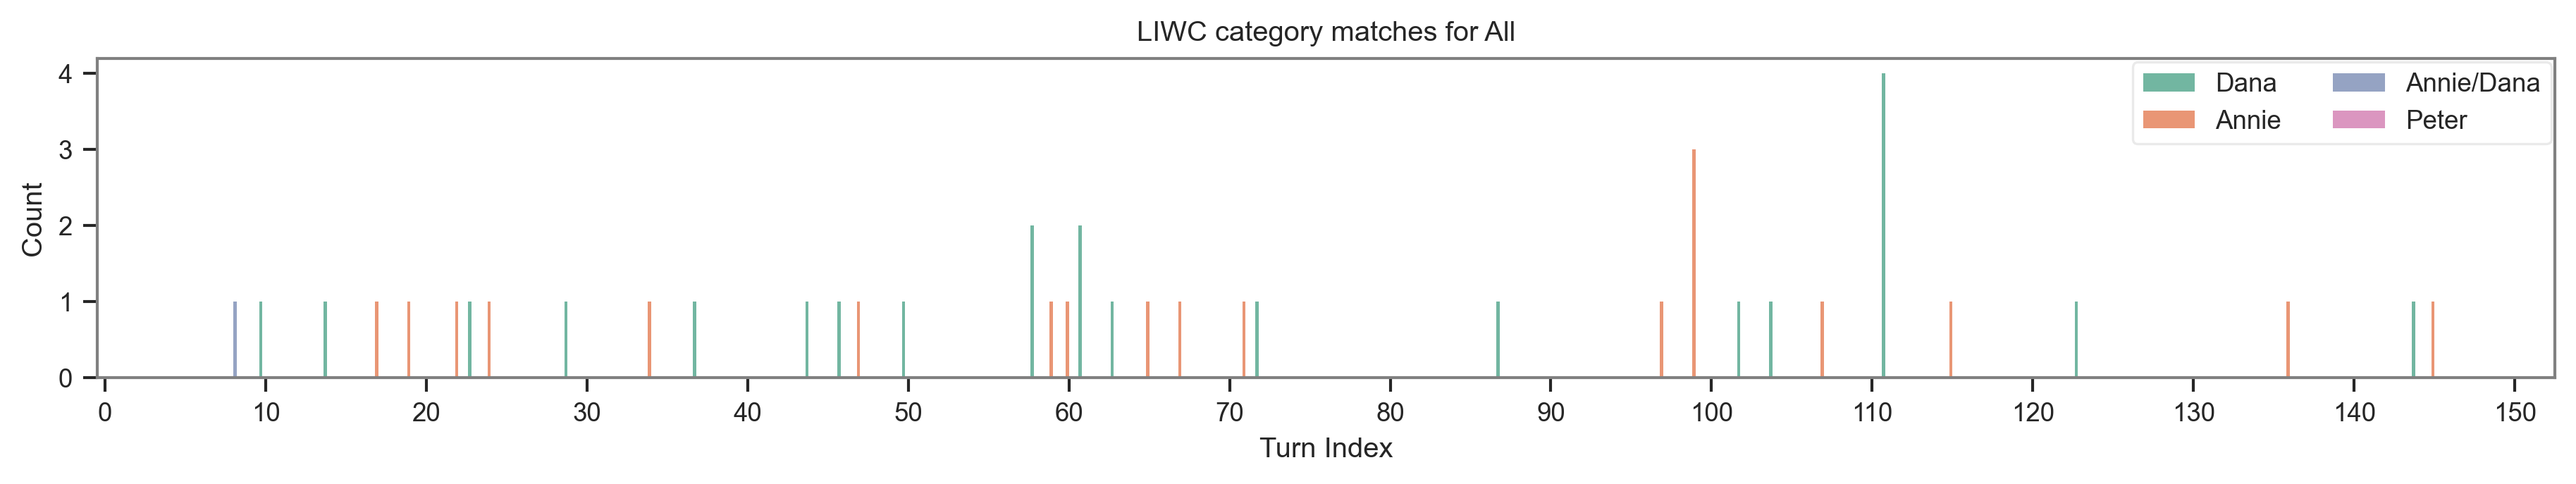

In [9]:
analysed_df = analyse_turns_liwc(transcript_df) 

In [10]:
analysed_df.sample(5)

,Speaker,Turn,Turn Index,Category,Count
130,Annie,Chirping?,130,None,0
11,Annie,"Sandwiches, sea, salmon on the beach, sandwic...",11,None,0
4,Annie,[Yea] Beach. Yea.,4,None,0
132,Annie,Yeah. Two.,132,None,0
139,Annie,Or icicles on fence,139,None,0


In [11]:
def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def count_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    num_matches = len(list(re.finditer(reg_str, sentence)))
    return num_matches

def count_words(sentence):
    words = sentence.split()
    return len(words)

def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print

def print_lines(df, dict_terms, start, num_lines=10):
    speakers_list = list(df['speaker'])
    turns = list(df['speech_turn'])
    end = start + num_lines
    for ind, line in enumerate(turns[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, dict_terms)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')

## Examine the Transcript in Detail
Based on the chart plotted, we can now use the function `print_lines` below to examine a sequence of terms such that all matching terms that fit a category are highlighted.

In [12]:
categories = list(liwc_dic_obj.keys())
categories

['CausalThinking']

In [13]:
category = 'CausalThinking'

In [14]:
liwc_terms = liwc_dic_obj[category]
print_lines(transcript_df, liwc_terms, 55, num_lines=6)

55 : Annie


 what::↓

----------
56 : Dana


 i think you should start the last sentence (.) i thought ↑ that he was going to do that

----------
57 : Annie


 yeah. that's that’s↑**how** it worked last time

----------
58 : Dana


 oh (3.0)  i can just tell it's time to break out <those hose or water cannons again> ↓, this was just too much to take (.) i don't know if you ever **used** one of these in your garden (.) but when you never **used** one typical celebration of the (.) it's weird

----------
59 : Annie


 yeah, i think it's just **generating** text ↓

----------
60 : Annie


 i think i will know. see if you **pick** words from. yeah, 

----------
